In [1]:
import pandas as pd
pd.set_option('display.max_columns', 100)
import numpy as np
import os
import pandas_profiling as pp
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from time import time

# Data overview

In [2]:
DATA_PATH='data/mushrooms.csv'

In [3]:
df=pd.read_csv(DATA_PATH)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

In [4]:
df.describe(include='all')

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,2,5,4,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,t,b,s,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,4608,3776,5176,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


In [5]:
df.drop_duplicates(inplace=True)
df.shape

(8124, 23)

veil-type has constant value 'p', so we will remove it

In [6]:
df['class'].value_counts()

e    4208
p    3916
Name: class, dtype: int64

In [7]:
report = pp.ProfileReport(df)

report.to_file("profile_report.html")

report

# Data processing

In [8]:
# drop columns contain single unique values: veil-type
df.drop('veil-type', axis=1, inplace=True)

In [9]:
np_data=df.to_numpy()
X=np_data[:, 1:]
Y=np_data[:, 0]
print(X.shape, Y.shape)
print(Y)

(8124, 21) (8124,)
['p' 'e' 'e' ... 'e' 'p' 'e']


In [10]:
# Encode each columns of data to spare form
for i in range(X.shape[1]):
    encoder=LabelEncoder()
    X[:, i]=encoder.fit_transform(X[:, i])
print(X.shape)
print(X)

(8124, 21)
[[5 2 4 ... 2 3 5]
 [5 2 9 ... 3 2 1]
 [0 2 8 ... 3 2 3]
 ...
 [2 2 4 ... 0 1 2]
 [3 3 4 ... 7 4 2]
 [5 2 4 ... 4 1 2]]


In [11]:
# train test split: 30% for testing
x_train, x_test, y_train, y_test=train_test_split(X, Y, test_size=0.3, random_state=42)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(5686, 21) (5686,) (2438, 21) (2438,)


# Training decision tree classifier

## Training a simple decision tree with depth=3

In [12]:
clf=DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=5)
clf.fit(x_train, y_train)
clf.score(x_test, y_test)

0.9811320754716981

## Visualize trained decision tree

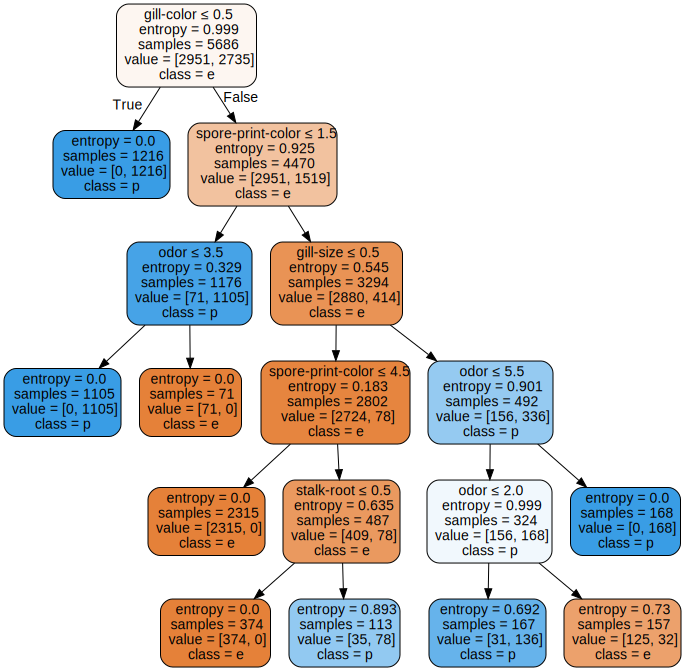

In [13]:
import graphviz
from sklearn.tree import export_graphviz
FEATURES=list(df.columns)[1:]
dot_data = export_graphviz(clf, out_file=None, feature_names= FEATURES,
                                class_names=['e', 'p'],  filled=True, rounded=True,  special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

# Grid search to find best hyper parameters

In [14]:
params={
    'criterion': ('gini', 'entropy'),
    'max_depth':(3, 5, 7, 9, 11),
    'min_samples_leaf': (3,5,10)
}

In [15]:
def grid_search(pipeline, parameters, x_train, y_train):
    # find the best parameters for both the feature extraction and the classifier
    grid_searcher = GridSearchCV(pipeline, parameters, n_jobs=-1,  verbose=10 )
    print("Performing grid search...")
    print("parameters:")
    print(parameters)
    t0 = time()
    grid_searcher.fit(x_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print("Best score: %0.3f" % grid_searcher.best_score_)
    print("Best parameters set:")
    best_estimator=grid_searcher.best_estimator_
    best_parameters = best_estimator.get_params()
    print(best_parameters)
    cv_results=pd.DataFrame(grid_searcher.cv_results_).sort_values(by='rank_test_score')
    return cv_results, best_estimator

In [16]:
clf=DecisionTreeClassifier()
cv_results, best_tree=grid_search(clf, params, x_train, y_train)

Performing grid search...
parameters:
{'criterion': ('gini', 'entropy'), 'max_depth': (3, 5, 7, 9, 11), 'min_samples_leaf': (3, 5, 10)}
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1124s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1837s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.7s


done in 1.995s
Best score: 1.000
Best parameters set:
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 7, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': None, 'splitter': 'best'}


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.9s finished


In [17]:
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
27,0.025463,0.005440,0.005430,0.000864,entropy,11,3,"{'criterion': 'entropy', 'max_depth': 11, 'min...",1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1
6,0.035427,0.007435,0.009369,0.005536,gini,7,3,"{'criterion': 'gini', 'max_depth': 7, 'min_sam...",1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1
9,0.029868,0.008220,0.010533,0.005231,gini,9,3,"{'criterion': 'gini', 'max_depth': 9, 'min_sam...",1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1
12,0.043100,0.005783,0.007747,0.003295,gini,11,3,"{'criterion': 'gini', 'max_depth': 11, 'min_sa...",1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1
25,0.034393,0.010938,0.007158,0.004224,entropy,9,5,"{'criterion': 'entropy', 'max_depth': 9, 'min_...",1.000000,1.000000,1.000000,1.000000,0.997361,0.999472,0.001055,5
24,0.029955,0.009186,0.011222,0.005532,entropy,9,3,"{'criterion': 'entropy', 'max_depth': 9, 'min_...",1.000000,1.000000,1.000000,1.000000,0.997361,0.999472,0.001055,5
22,0.038850,0.016451,0.008449,0.004047,entropy,7,5,"{'criterion': 'entropy', 'max_depth': 7, 'min_...",1.000000,1.000000,1.000000,1.000000,0.997361,0.999472,0.001055,5
28,0.023501,0.004064,0.005937,0.001948,entropy,11,5,"{'criterion': 'entropy', 'max_depth': 11, 'min...",1.000000,1.000000,1.000000,1.000000,0.997361,0.999472,0.001055,5
21,0.038739,0.008125,0.008252,0.003592,entropy,7,3,"{'criterion': 'entropy', 'max_depth': 7, 'min_...",1.000000,1.000000,1.000000,1.000000,0.997361,0.999472,0.001055,5
10,0.037454,0.017126,0.008241,0.002136,gini,9,5,"{'criterion': 'gini', 'max_depth': 9, 'min_sam...",1.000000,1.000000,0.996482,1.000000,1.000000,0.999296,0.001407,10


In [18]:
best_tree.score(x_test, y_test)

1.0

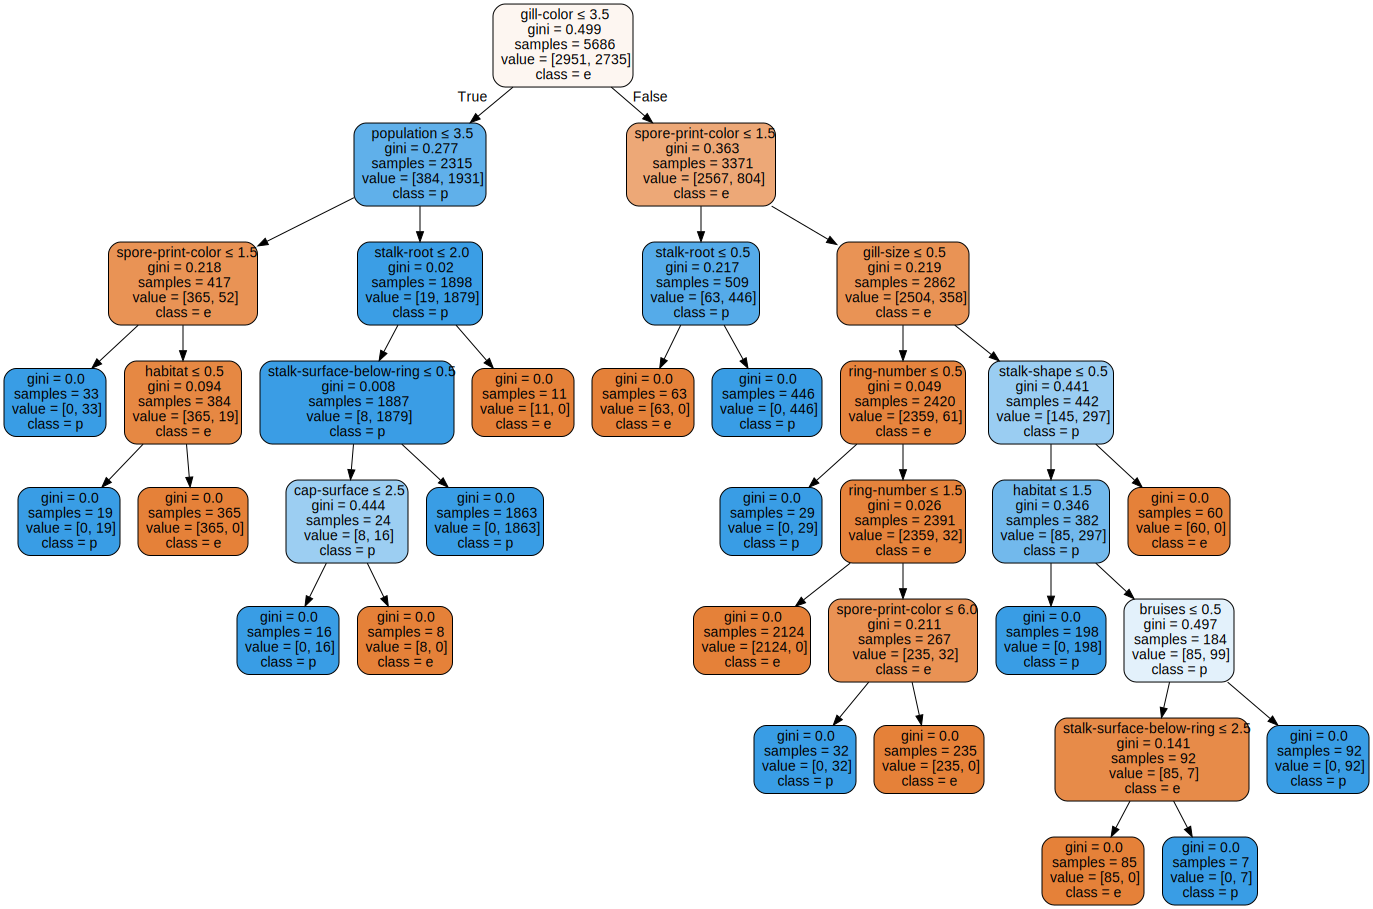

In [19]:
dot_data = export_graphviz(best_tree, out_file=None, feature_names= FEATURES,
                                class_names=['e', 'p'],  filled=True, rounded=True,  special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

# Feature importance

In [20]:
from matplotlib import pyplot as plt
f_imp=best_tree.feature_importances_
print(f_imp)

[0.         0.00375733 0.         0.02766307 0.         0.
 0.         0.11013023 0.34302226 0.02208304 0.04652939 0.
 0.00641104 0.         0.         0.         0.02204913 0.
 0.21095618 0.18033672 0.02706163]


In [21]:
# used and unused features in the above best decision tree
used_f=[i for i in range(len(FEATURES)) if f_imp[i]!=0]
print(used_f)
unused_f=[i for i in range(len(FEATURES)) if f_imp[i]==0]
print(unused_f)

[1, 3, 7, 8, 9, 10, 12, 16, 18, 19, 20]
[0, 2, 4, 5, 6, 11, 13, 14, 15, 17]


[('cap-shape', 0.0), ('cap-color', 0.0), ('odor', 0.0), ('gill-attachment', 0.0), ('gill-spacing', 0.0), ('stalk-surface-above-ring', 0.0), ('stalk-color-above-ring', 0.0), ('stalk-color-below-ring', 0.0), ('veil-color', 0.0), ('ring-type', 0.0), ('cap-surface', 0.0037573274307080642), ('stalk-surface-below-ring', 0.0064110397574098235), ('ring-number', 0.022049126454418397), ('stalk-shape', 0.02208303861862095), ('habitat', 0.027061625462437608), ('bruises', 0.027663067955365935), ('stalk-root', 0.04652938577094006), ('gill-size', 0.11013022925062349), ('population', 0.1803367223678637), ('spore-print-color', 0.21095618043957357), ('gill-color', 0.3430222564920383)]


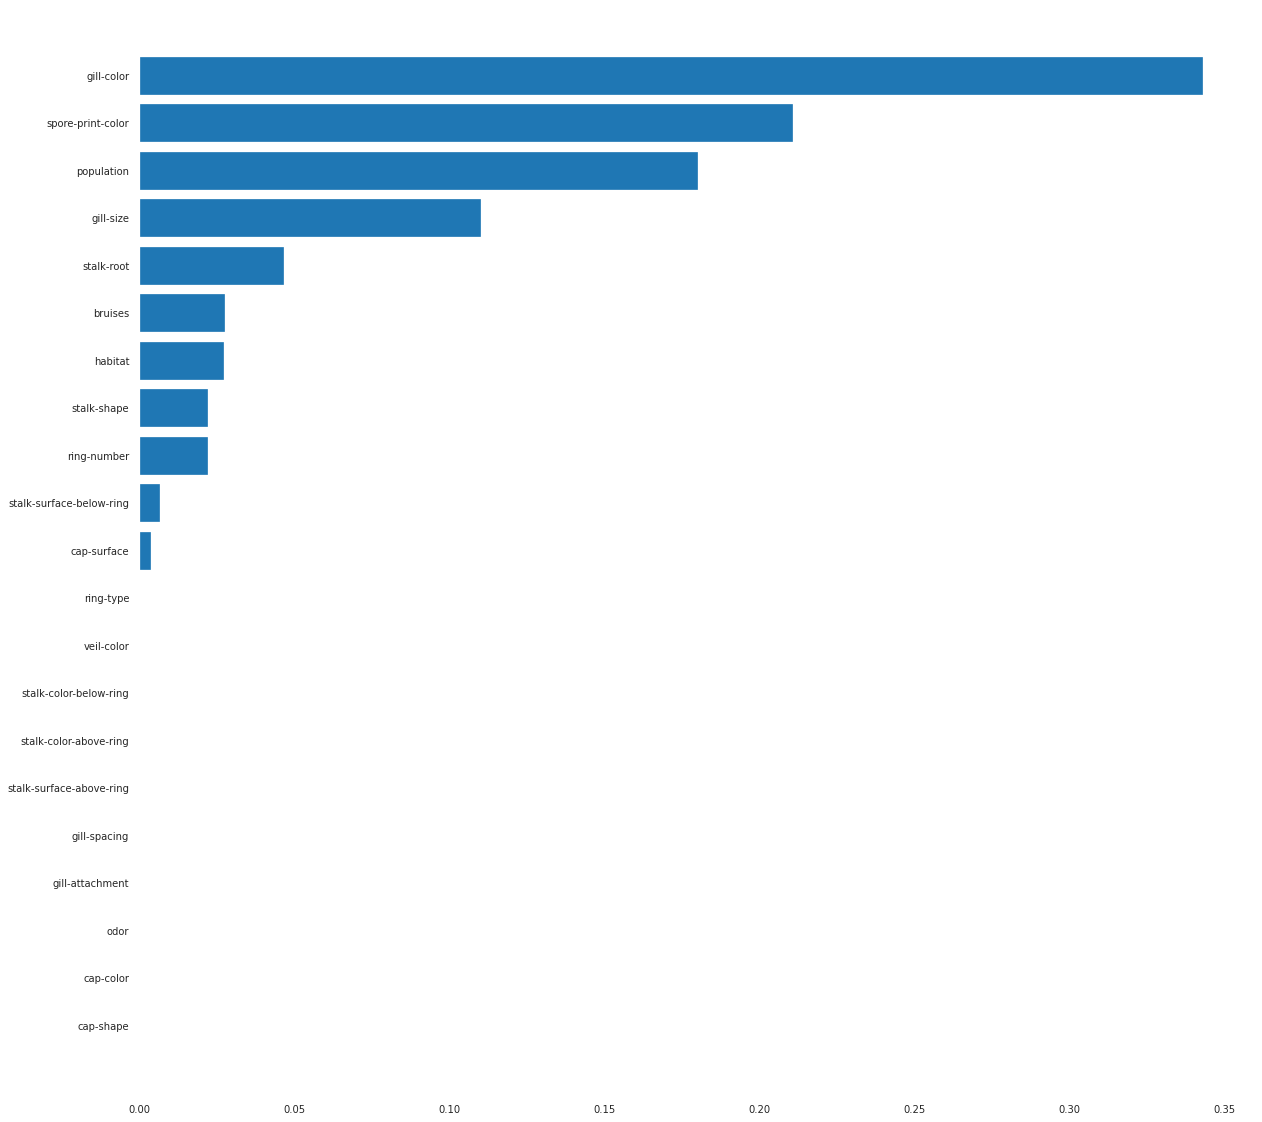

In [22]:
# Plot feature importances
f_imp=[(f, f_imp[i]) for i, f in enumerate(FEATURES)]
f_imp.sort(key=lambda x: x[1])
f_names=[x[0] for x in f_imp]
f_score=[x[1] for x in f_imp]
print(f_imp)
plt.subplots(figsize=(20,20))
plt.barh(np.arange(len(f_score)), f_score, tick_label=f_names)
plt.show()

## Try to retrain the classifier with the same hyper parameters and used features only  
This process should output the exactly same results as best tree founed by gridsearchCV above

In [23]:
x_train_subset=x_train[:, used_f]
x_test_subset=x_test[:, used_f]
clf=DecisionTreeClassifier(criterion='gini', max_depth=7, min_samples_leaf=3)
clf.fit(x_train_subset, y_train)
clf.score(x_test_subset, y_test)

1.0

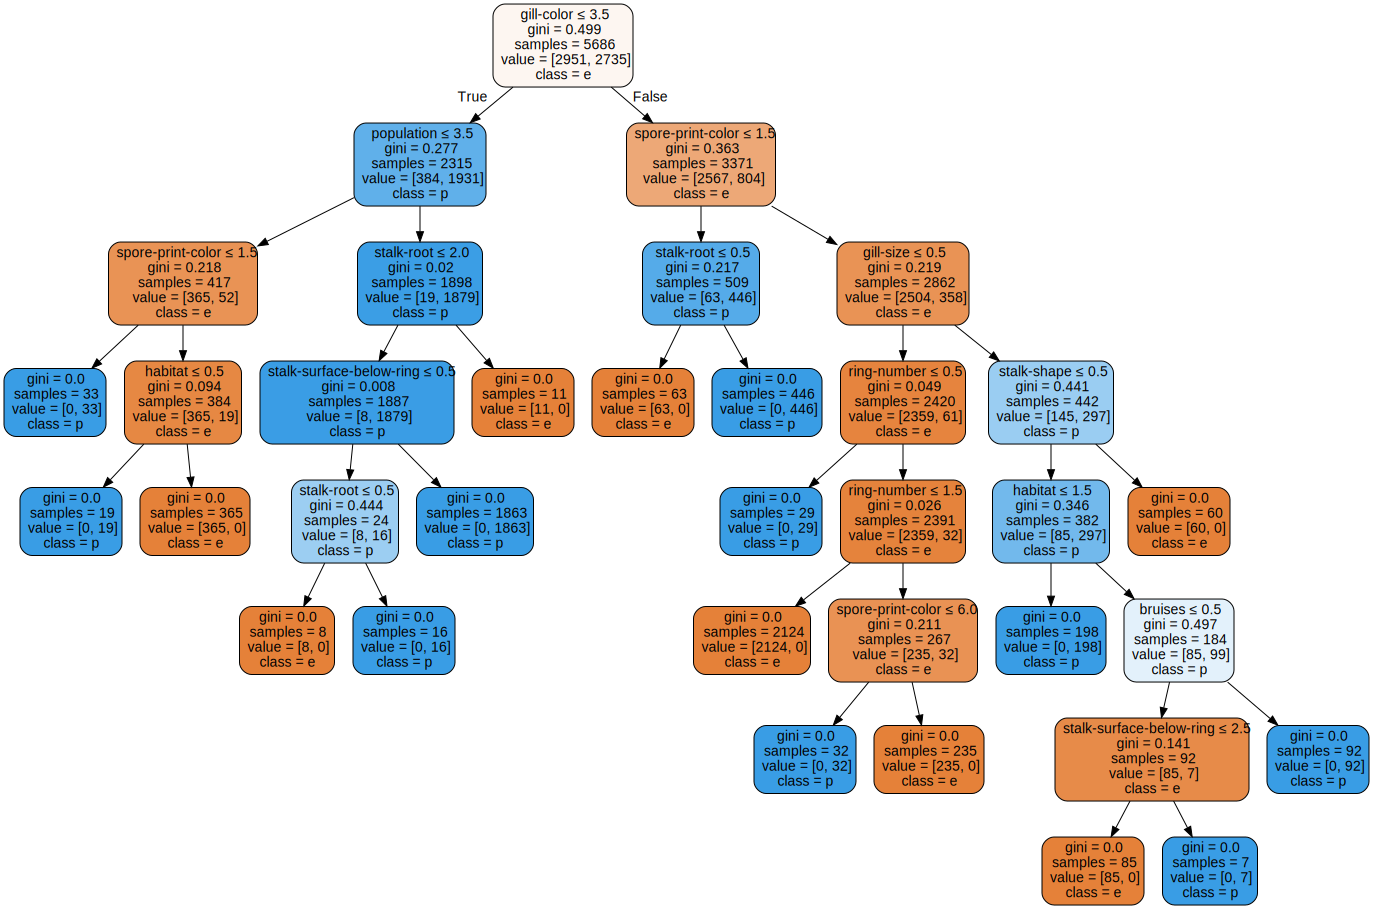

In [24]:
dot_data = export_graphviz(clf, out_file=None, feature_names= np.array(FEATURES)[used_f],
                                class_names=['e', 'p'],  filled=True, rounded=True,  special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

Note: Decision graph visualized for this tree is exactly the same as best tree above

## Try to retrain the classifier with unused features
This process may output bad results

In [25]:
x_train_subset=x_train[:, unused_f]
x_test_subset=x_test[:, unused_f]
clf=DecisionTreeClassifier(criterion='gini', max_depth=7, min_samples_leaf=3)
clf.fit(x_train_subset, y_train)
clf.score(x_test_subset, y_test)

0.9901558654634947

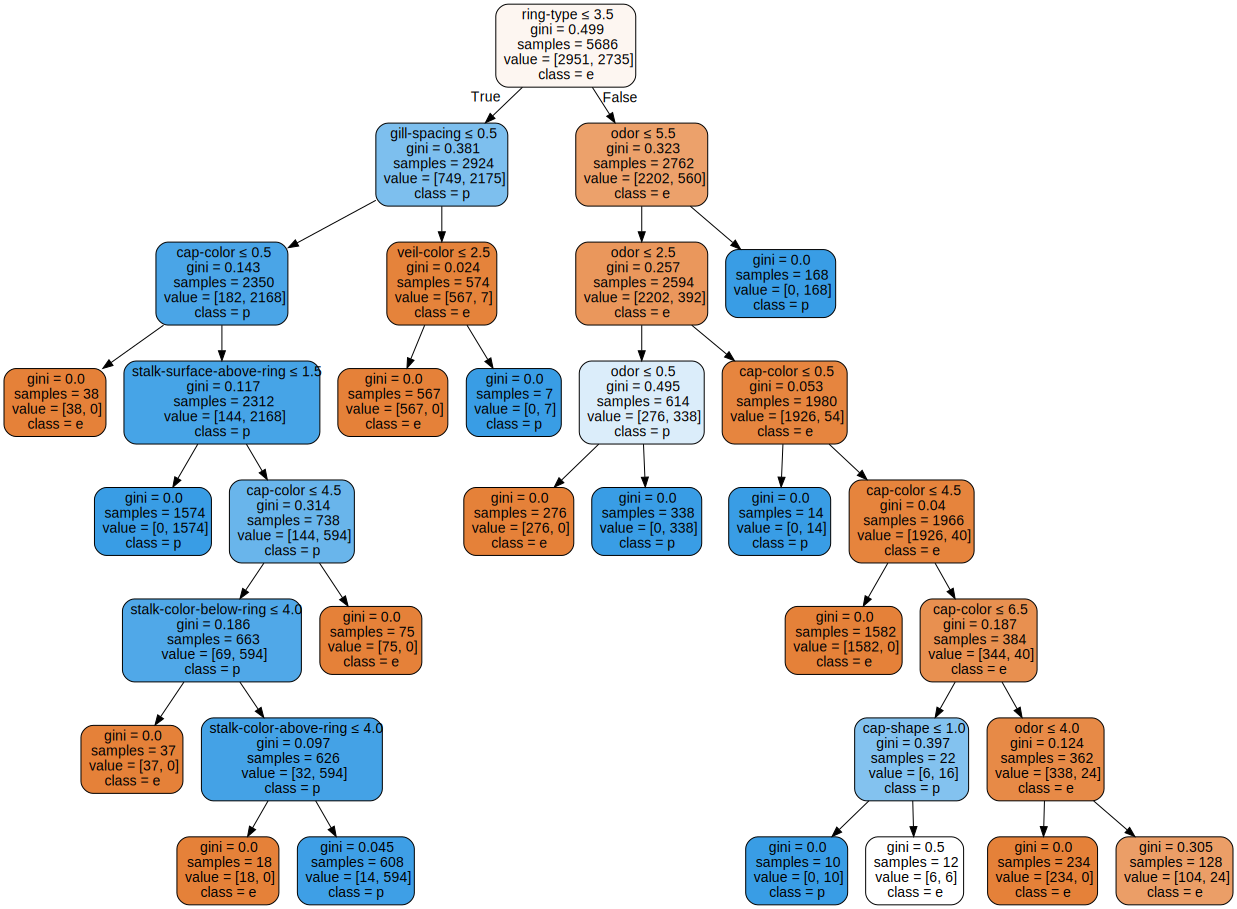

In [26]:
dot_data = export_graphviz(clf, out_file=None, feature_names= np.array(FEATURES)[unused_f],
                                class_names=['e', 'p'],  filled=True, rounded=True,  special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

Note: the accuracy on test set is 92.5%, which is not very bad.. This classification task seems to be quite easy since each features are discriminative between the two classes.